In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load and prepare the dataset
data = pd.read_csv('HR_Employee_Cleaned.csv')
X = data.drop('Attrition', axis=1).values
y = data['Attrition'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Core XGBoost components
class DecisionNode:
    """Represents a decision node or leaf in the tree."""
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx  # Feature index for split
        self.threshold = threshold      # Threshold value for split
        self.left = left                # Left subtree
        self.right = right              # Right subtree
        self.value = value              # Leaf value (if leaf node)

class XGBoostTree:
    """Single tree in XGBoost, built using gradient and hessian."""
    def __init__(self, max_depth=3, reg_lambda=1.0, gamma=0.0):
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.root = None

    @staticmethod
    def _compute_gain(g_left, h_left, g_right, h_right, g_total, h_total, reg_lambda, gamma):
        """Calculate gain for a split."""
        gain = (g_left**2 / (h_left + reg_lambda) +
                g_right**2 / (h_right + reg_lambda) -
                g_total**2 / (h_total + reg_lambda)) - gamma
        return gain

    def _best_split(self, X, g, h, feature_indices):
        """Find the best split for a node."""
        best_gain = -np.inf
        best_feature, best_threshold = None, None
        g_total, h_total = g.sum(), h.sum()

        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                g_left, h_left = g[left_mask].sum(), h[left_mask].sum()
                g_right, h_right = g[~left_mask].sum(), h[~left_mask].sum()
                gain = self._compute_gain(g_left, h_left, g_right, h_right,
                                         g_total, h_total, self.reg_lambda, self.gamma)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        return best_feature, best_threshold, best_gain

    def _grow_tree(self, X, g, h, depth=0):
        """Recursively grow the tree."""
        if depth >= self.max_depth or X.shape[0] < 2:
            leaf_value = -g.sum() / (h.sum() + self.reg_lambda)
            return DecisionNode(value=leaf_value)

        feature_indices = np.random.choice(X.shape[1], size=int(np.sqrt(X.shape[1])), replace=False)
        feature, threshold, gain = self._best_split(X, g, h, feature_indices)

        if gain < 0:  # Stop if no positive gain
            leaf_value = -g.sum() / (h.sum() + self.reg_lambda)
            return DecisionNode(value=leaf_value)

        left_mask = X[:, feature] <= threshold
        left = self._grow_tree(X[left_mask], g[left_mask], h[left_mask], depth+1)
        right = self._grow_tree(X[~left_mask], g[~left_mask], h[~left_mask], depth+1)
        return DecisionNode(feature_idx=feature, threshold=threshold, left=left, right=right)

    def fit(self, X, g, h):
        """Fit the tree to gradients (g) and hessians (h)."""
        self.root = self._grow_tree(X, g, h)

    def predict_instance(self, x, node):
        """Predict a single instance."""
        if node.value is not None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self.predict_instance(x, node.left)
        else:
            return self.predict_instance(x, node.right)

    def predict(self, X):
        """Predict for multiple instances."""
        return np.array([self.predict_instance(x, self.root) for x in X])

class XGBoostClassifier:
    """XGBoost classifier from scratch."""
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1.0, gamma=0.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.trees = []
        self.base_pred = None

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def _gradient(self, y, y_pred):
        return y_pred - y

    def _hessian(self, y_pred):
        return y_pred * (1 - y_pred)

    def fit(self, X, y):
        # Initialize base prediction (log-odds)
        self.base_pred = np.log(np.mean(y) / (1 - np.mean(y))) if np.mean(y) != 0 else 0
        y_pred = np.full_like(y, self.base_pred, dtype=float)

        for _ in range(self.n_estimators):
            # Compute gradients and hessians
            p = self.sigmoid(y_pred)
            g = self._gradient(y, p)
            h = self._hessian(p)

            # Fit a tree to the gradients
            tree = XGBoostTree(max_depth=self.max_depth,
                              reg_lambda=self.reg_lambda,
                              gamma=self.gamma)
            tree.fit(X, g, h)
            tree_pred = tree.predict(X)

            # Update predictions with learning rate
            y_pred -= self.learning_rate * tree_pred
            self.trees.append(tree)

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], self.base_pred)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Training and evaluation
params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'reg_lambda': 1.0,
    'gamma': 0.0
}

model = XGBoostClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.8357


C:\Users\soulf\AppData\Local\Temp\ipykernel_26200\1060610857.py:106: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


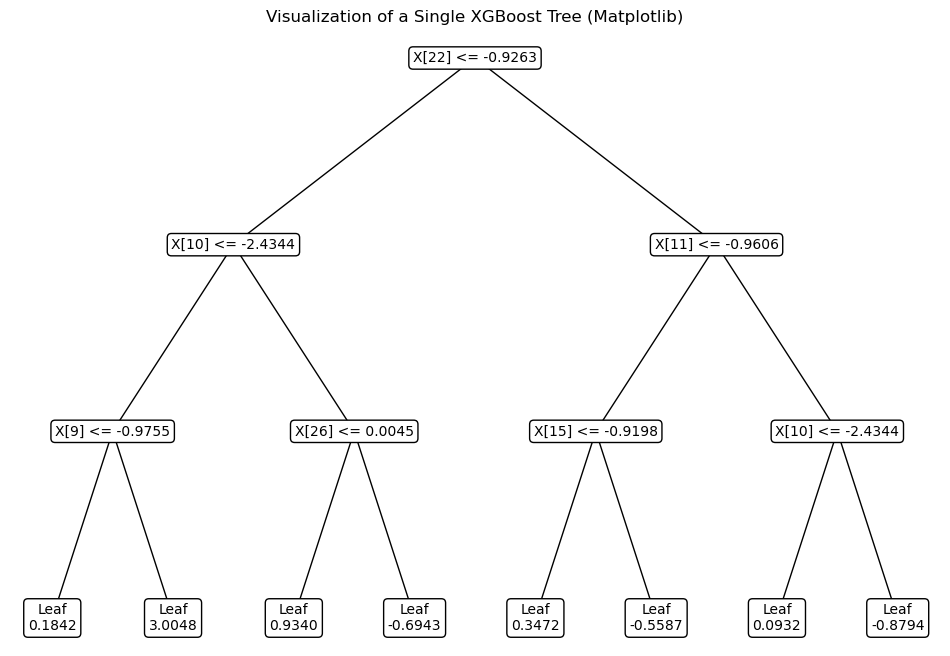

In [2]:
import matplotlib.pyplot as plt

def assign_positions(node, depth=0, pos_dict=None, x=0):
    """
    Recursively assign (x, y) positions to each node using in-order traversal.
    
    Parameters:
        node (DecisionNode): The current node.
        depth (int): Current depth of the node.
        pos_dict (dict): Dictionary mapping node to its (x, y) coordinates.
        x (int): Current x-position counter.
    
    Returns:
        int: The next available x position after processing this subtree.
    """
    if pos_dict is None:
        pos_dict = {}
        
    # Traverse left subtree if it exists.
    if node.left is not None:
        x = assign_positions(node.left, depth + 1, pos_dict, x)
    
    # Assign current node position. y is negative depth for top-down layout.
    pos_dict[node] = (x, -depth)
    x += 1  # Increment x for the next node.
    
    # Traverse right subtree if it exists.
    if node.right is not None:
        x = assign_positions(node.right, depth + 1, pos_dict, x)
    
    return x

def plot_tree_matplotlib(node, pos_dict, ax):
    """
    Recursively plot the tree nodes and edges using matplotlib.
    
    Parameters:
        node (DecisionNode): The current node.
        pos_dict (dict): Dictionary mapping nodes to (x, y) positions.
        ax (Axes): Matplotlib axes object.
    """
    x, y = pos_dict[node]
    
    # Create a label for the node.
    if node.value is not None:
        label = f"Leaf\n{node.value:.4f}"
    else:
        label = f"X[{node.feature_idx}] <= {node.threshold:.4f}"
    
    # Draw the node with a rounded box.
    ax.text(x, y, label, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="black", lw=1))
    
    # Draw edge and recursively plot left child.
    if node.left is not None:
        left_x, left_y = pos_dict[node.left]
        ax.plot([x, left_x], [y, left_y], 'k-', lw=1)
        plot_tree_matplotlib(node.left, pos_dict, ax)
    
    # Draw edge and recursively plot right child.
    if node.right is not None:
        right_x, right_y = pos_dict[node.right]
        ax.plot([x, right_x], [y, right_y], 'k-', lw=1)
        plot_tree_matplotlib(node.right, pos_dict, ax)

# Visualize the first tree from the ensemble.
tree_to_visualize = model.trees[0]  # Use the first tree for visualization.

# Create a dictionary to store positions and compute positions.
positions = {}
assign_positions(tree_to_visualize.root, depth=0, pos_dict=positions, x=0)

# Plot the tree using matplotlib.
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree_matplotlib(tree_to_visualize.root, positions, ax)
ax.set_axis_off()
plt.title("Visualization of a Single XGBoost Tree (Matplotlib)")
plt.show()
